In [4]:
!pip install unsloth trl peft accelerate bitsandbytes xformers transformers datasets qwen-vl-utils -q

In [5]:
import torch
import pandas as pd
from unsloth import FastVisionModel, UnslothVisionDataCollator
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import Dataset, load_dataset
import gc
import psutil

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-31 12:46:09.687831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756644369.910479      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756644369.975469      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
# Paths
csv_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Load CSV and clean column names
df = pd.read_csv(csv_path, delimiter='|')
df.columns = [col.strip() for col in df.columns]
print("Dataset columns:", df.columns)

# Rename 'comment' to 'caption' if needed
if 'comment' in df.columns:
    df.rename(columns={'comment': 'caption'}, inplace=True)

# Select 100 unique images
unique_images = df['image_name'].unique()[:100]
df = df[df['image_name'].isin(unique_images)]

# Create image paths
df['image_path'] = image_dir + df['image_name']

# Filter out invalid images
def check_image(sample):
    try:
        from PIL import Image
        img = Image.open(sample['image_path'])
        img.verify()  # Verify image integrity
        img = Image.open(sample['image_path'])  # Reopen after verify
        img.load()  # Ensure image can be fully loaded
        return True
    except Exception as e:
        print(f"Skipping image {sample['image_path']}: {e}")
        return False

# Apply filter
raw_dataset = Dataset.from_pandas(df)
raw_dataset = raw_dataset.filter(check_image, batched=False)
print(f"Loaded {len(raw_dataset)} samples (from 100 unique images).")

# Ensure some samples remain
if len(raw_dataset) == 0:
    raise ValueError("No valid images found. Check dataset paths or files.")

Dataset columns: Index(['image_name', 'comment_number', 'comment'], dtype='object')


Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Loaded 500 samples (from 100 unique images).


In [7]:
# Prompts
system_message = "You are an AI visual assistant that can analyze images in detail."
user_prompt = "Describe the following image in detail."

# Formatting function
def format_data(sample):
    return {
        "messages": [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}]
            },
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample["image_path"]},
                    {"type": "text", "text": user_prompt}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["caption"]}]
            }
        ]
    }

# Apply formatting
formatted_dataset = raw_dataset.map(format_data, remove_columns=raw_dataset.column_names)

# Verify dataset structure
print("Sample formatted data:", formatted_dataset[0])

# Split into train/eval (10% eval)
dataset = formatted_dataset.train_test_split(test_size=0.1)
train_dataset = dataset['train']
eval_dataset = dataset['test']
print(f"Training samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Sample formatted data: {'messages': [{'content': [{'image': None, 'text': 'You are an AI visual assistant that can analyze images in detail.', 'type': 'text'}], 'role': 'system'}, {'content': [{'image': '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg', 'text': None, 'type': 'image'}, {'image': None, 'text': 'Describe the following image in detail.', 'type': 'text'}], 'role': 'user'}, {'content': [{'image': None, 'text': ' Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'type': 'text'}], 'role': 'assistant'}]}
Training samples: 450, Eval samples: 50


In [8]:
try:
    dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
except AttributeError:
    dtype = torch.float16

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct",
    load_in_4bit=True,
    dtype=dtype,
)

# Access the underlying tokenizer for Qwen2VLProcessor
processor = tokenizer
actual_tokenizer = processor.tokenizer

# Verify <|image_pad|> and <|image|> in vocabulary
special_tokens = ["<|image_pad|>", "<|image|>"]
tokens_to_add = [token for token in special_tokens if token not in actual_tokenizer.get_vocab()]
if tokens_to_add:
    actual_tokenizer.add_special_tokens({"additional_special_tokens": tokens_to_add})
    model.resize_token_embeddings(len(actual_tokenizer))
    print(f"Added {tokens_to_add} to tokenizer vocabulary")
else:
    print("All special tokens already in tokenizer vocabulary")

# Debug: Verify token IDs
print(f"<|image_pad|> token ID: {actual_tokenizer.convert_tokens_to_ids('<|image_pad|>')}")
print(f"<|image|> token ID: {actual_tokenizer.convert_tokens_to_ids('<|image|>')}")

# Set explicit chat template using <|image_pad|>
processor.tokenizer.chat_template = """
{% for message in messages %}
    {% if message['role'] == 'system' %}
        <|im_start|>system
        {{ message['content'][0]['text'] }}<|im_end>
    {% elif message['role'] == 'user' %}
        <|im_start|>user
        {% for content in message['content'] %}
            {% if content['type'] == 'image' %}
                <|image_pad|>
            {% elif content['type'] == 'text' %}
                {{ content['text'] }}
            {% endif %}
        {% endfor %}
        <|im_end>
    {% elif message['role'] == 'assistant' %}
        <|im_start|>assistant
        {{ message['content'][0]['text'] }}<|im_end>
    {% endif %}
{% endfor %}
"""

# Prepare LoRA
model = FastVisionModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=42,
    use_rslora=False,
    loftq_config=None,
)

# Data collator (use processor, not tokenizer)
data_collator = UnslothVisionDataCollator(model, processor)

==((====))==  Unsloth 2025.8.10: Fast Qwen2_Vl patching. Transformers: 4.56.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Added ['<|image|>'] to tokenizer vocabulary
<|image_pad|> token ID: 151655
<|image|> token ID: 151657
Unsloth: Making `model.base_model.model.model.language_model` require gradients
Unsloth: Model does not have a default image size - using 512


In [21]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    max_seq_length=1024,
    data_collator=data_collator,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=2,
        warmup_steps=5,
        num_train_epochs=3,
        learning_rate=5e-6,
        fp16=not torch.cuda.is_bf16_supported() if hasattr(torch.cuda, 'is_bf16_supported') else True,
        bf16=torch.cuda.is_bf16_supported() if hasattr(torch.cuda, 'is_bf16_supported') else False,
        logging_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=42,
        output_dir="outputs",
        eval_strategy="steps",
        eval_steps=20,
        save_strategy="steps",
        save_steps=20,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
    ),
)

# Monitor resources
print("Pre-training RAM usage:", psutil.virtual_memory().used / (1024 ** 3), "GB")
print("Pre-training VRAM usage:", torch.cuda.memory_allocated() / (1024 ** 3), "GB")

Pre-training RAM usage: 3.6623916625976562 GB
Pre-training VRAM usage: 2.5124106407165527 GB


In [ ]:
!pip install unsloth --upgrade -q
!pip install transformers --upgrade -q

In [23]:
from PIL import Image
import torch

def debug_collator(examples, processor):  # Accept processor as an argument
    images = []
    texts = []
    
    # Verify <|image_pad|> is in the tokenizer's vocabulary
    if "<|image_pad|>" not in processor.tokenizer.get_vocab():
        processor.tokenizer.add_special_tokens({"additional_special_tokens": ["<|image_pad|>"]})
        print("Added <|image_pad|> to tokenizer vocabulary")
    
    # Debug: Verify token IDs
    image_pad_token_id = processor.tokenizer.convert_tokens_to_ids("<|image_pad|>")
    image_token_id = processor.tokenizer.convert_tokens_to_ids("<|image|>")
   
    # Set chat template to use <|image_pad|> (for safety)
    processor.tokenizer.chat_template = """
{% for message in messages %}
    {% if message['role'] == 'system' %}
        <|im_start|>system
        {{ message['content'][0]['text'] }}<|im_end>
    {% elif message['role'] == 'user' %}
        <|im_start|>user
        {% for content in message['content'] %}
            {% if content['type'] == 'image' %}
                <|image_pad|>
            {% elif content['type'] == 'text' %}
                {{ content['text'] }}
            {% endif %}
        {% endfor %}
        <|im_end>
    {% elif message['role'] == 'assistant' %}
        <|im_start|>assistant
        {{ message['content'][0]['text'] }}<|im_end>
    {% endif %}
{% endfor %}
"""
    
    for i, ex in enumerate(examples):

        # Apply chat template using processor's tokenizer
        text = processor.tokenizer.apply_chat_template(ex["messages"], tokenize=False)
        image_count = text.count("<|image_pad|>")
        # Extract image path
        user_message = ex["messages"][1]["content"]
        image_path = next((item["image"] for item in user_message if isinstance(item, dict) and item["type"] == "image"), None)
        if image_path:
            try:
                img = Image.open(image_path).convert("RGB")  # Ensure RGB format
                images.append(img)
            except Exception as e:
                print(f"Example {i}: Failed to load image {image_path}: {e}")
                images.append(None)  # Append None to maintain batch alignment
        else:
            print(f"Example {i}: No image path found")
            images.append(None)
        texts.append(text)
    
    
    try:
        # Process texts and images together using Qwen2VLProcessor
        valid_images = [img for img in images if img is not None]
        if not valid_images:
            raise ValueError("No valid images in batch")
        
        batch = processor(
            text=texts,
            images=valid_images,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024,
            # Let processor handle image_grid_thw automatically
        )
        # Debug: Check input_ids for <|image_pad|> token
    
        if image_pad_token_id is not None:
            print(f"Contains <|image_pad|> token: {(batch['input_ids'] == image_pad_token_id).any().item()}")
        else:
            print("Cannot check for <|image_pad|> token: token ID is None")
            tokens = processor.tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
            print(f"Tokenized first example: {tokens}")
        
        # Ensure labels are included for training
        batch["labels"] = batch["input_ids"].clone()
        print("Processor succeeded")
        return batch
    except Exception as e:
        print(f"Processor failed: {e}")
        raise

# Update trainer with debug collator, using processing_class to address deprecation warning
trainer.data_collator = lambda examples: debug_collator(examples, processor=trainer.processing_class)  # Use trainer's processor

# Train
try:
    trainer.train()
except Exception as e:
    print(f"Training failed: {e}")
    raise

# Clear cache
gc.collect()
torch.cuda.empty_cache()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 450 | Num Epochs = 3 | Total steps = 339
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 18,464,768 of 2,227,023,360 (0.83% trained)


Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded


Step,Training Loss,Validation Loss,entropy
20,8.148300,7.873148,0
40,7.933800,7.507941,No Log
60,7.537400,7.276371,No Log
80,7.410900,7.107182,No Log
100,7.492200,6.984211,No Log
120,7.080100,6.897317,No Log
140,6.919300,6.823560,No Log
160,7.129800,6.754452,No Log
180,7.024300,6.692891,No Log
200,6.877400,6.638361,No Log


Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <|image_pad|> token: True
Processor succeeded
Contains <

In [24]:
# Save model and tokenizer
trainer.save_model("/kaggle/working/fine_tuned_qwen2_vl_2b_100_two")
tokenizer.save_pretrained("/kaggle/working/fine_tuned_qwen2_vl_2b_100")

[]

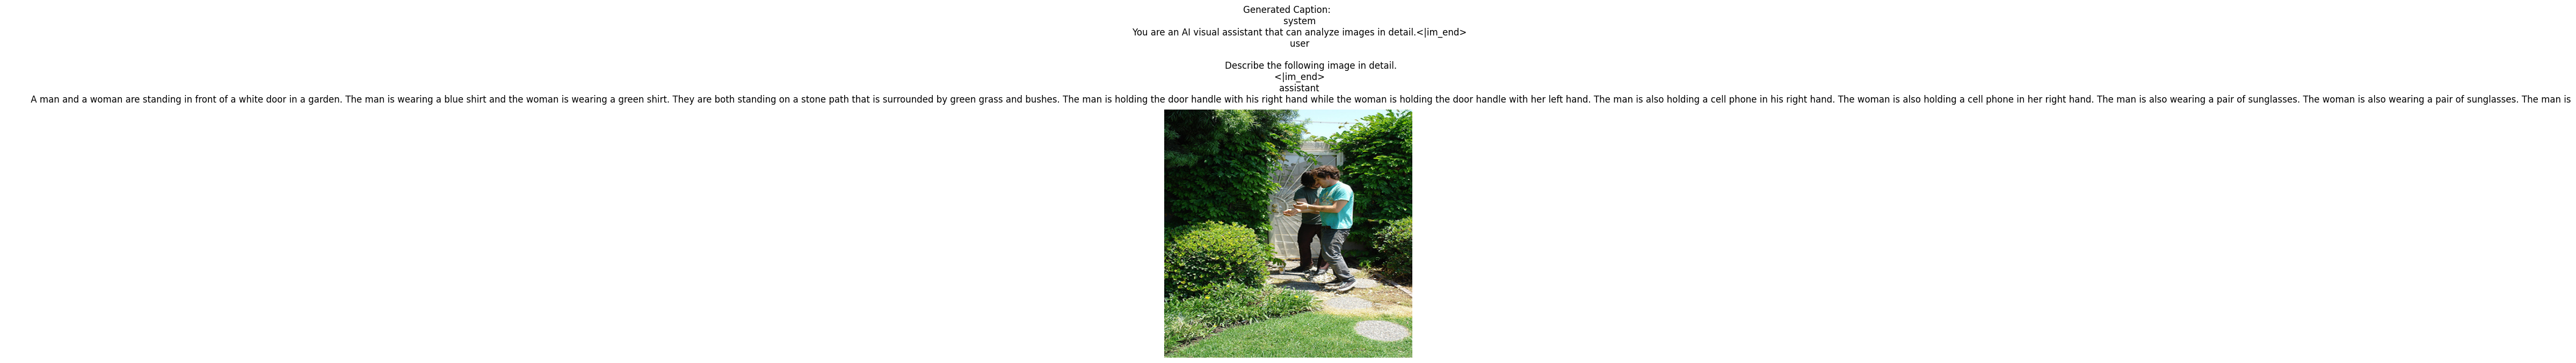

In [25]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizer parallelism warning

from PIL import Image
import torch
import logging
import matplotlib.pyplot as plt
from IPython.display import display
from transformers import Qwen2VLProcessor

# Configure logging to file for debugging
logging.basicConfig(
    filename="inference.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths and prompts
test_image_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg"
system_message = "You are an AI visual assistant that can analyze images in detail."
user_prompt = "Describe the following image in detail."

# Load model and processor
try:
    # If model and processor are in memory from training
    model = trainer.model
    processor = trainer.processing_class
except NameError:
    # Load from saved checkpoint
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        "outputs",  # Update to your saved checkpoint path
        load_in_4bit=True,
        dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    )
    processor = Qwen2VLProcessor.from_pretrained("unsloth/Qwen2-VL-2B-Instruct")

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Load and preprocess image
try:
    image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # Resize for consistency
    logger.info(f"Image loaded successfully: {test_image_path}")
except Exception as e:
    logger.error(f"Failed to load image {test_image_path}: {e}")
    print(f"Error: Failed to load image. Check inference.log for details.")
    raise

# Prepare messages
messages = [
    {"role": "system", "content": [{"type": "text", "text": system_message}]},
    {"role": "user", "content": [
        {"type": "image", "image": test_image_path},  # Path for message structure
        {"type": "text", "text": user_prompt}
    ]}
]

try:
    # Apply chat template
    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    logger.info(f"Applied chat template: {text}")

    # Process text and image
    inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
    logger.info(f"Inputs prepared: input_ids shape {inputs['input_ids'].shape}, pixel_values shape {inputs.get('pixel_values', 'Not present').shape}")

    # Generate caption
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    
    # Display image and caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Generated Caption: {generated_text}", fontsize=12, pad=10)
    plt.show()

except Exception as e:
    logger.error(f"Inference failed: {e}")
    print(f"Inference failed: Check inference.log for details")
    raise

# Clear cache
import gc
gc.collect()
torch.cuda.empty_cache()

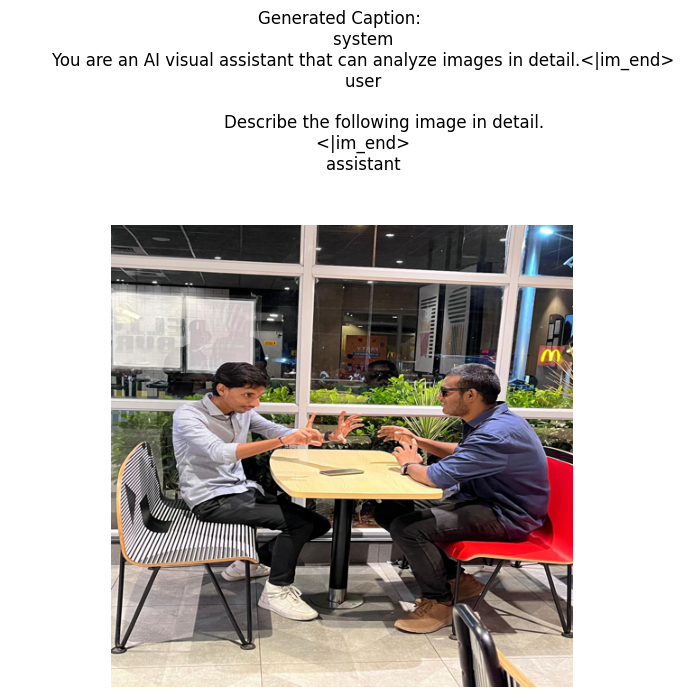

In [26]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizer parallelism warning

from PIL import Image
import torch
import logging
import matplotlib.pyplot as plt
from IPython.display import display
from transformers import Qwen2VLProcessor

# Configure logging to file for debugging
logging.basicConfig(
    filename="inference.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths and prompts
test_image_path = "/kaggle/input/sample2/WhatsApp Image 2025-04-23 at 10.46.47_3fe839c9.jpg"
system_message = "You are an AI visual assistant that can analyze images in detail."
user_prompt = "Describe the following image in detail."

# Load model and processor
try:
    # If model and processor are in memory from training
    model = trainer.model
    processor = trainer.processing_class
except NameError:
    # Load from saved checkpoint
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        "outputs",  # Update to your saved checkpoint path
        load_in_4bit=True,
        dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    )
    processor = Qwen2VLProcessor.from_pretrained("unsloth/Qwen2-VL-2B-Instruct")

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Load and preprocess image
try:
    image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # Resize for consistency
    logger.info(f"Image loaded successfully: {test_image_path}")
except Exception as e:
    logger.error(f"Failed to load image {test_image_path}: {e}")
    print(f"Error: Failed to load image. Check inference.log for details.")
    raise

# Prepare messages
messages = [
    {"role": "system", "content": [{"type": "text", "text": system_message}]},
    {"role": "user", "content": [
        {"type": "image", "image": test_image_path},  # Path for message structure
        {"type": "text", "text": user_prompt}
    ]}
]

try:
    # Apply chat template
    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    logger.info(f"Applied chat template: {text}")

    # Process text and image
    inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
    logger.info(f"Inputs prepared: input_ids shape {inputs['input_ids'].shape}, pixel_values shape {inputs.get('pixel_values', 'Not present').shape}")

    # Generate caption
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    
    # Display image and caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Generated Caption: {generated_text}", fontsize=12, pad=10)
    plt.show()

except Exception as e:
    logger.error(f"Inference failed: {e}")
    print(f"Inference failed: Check inference.log for details")
    raise

# Clear cache
import gc
gc.collect()
torch.cuda.empty_cache()

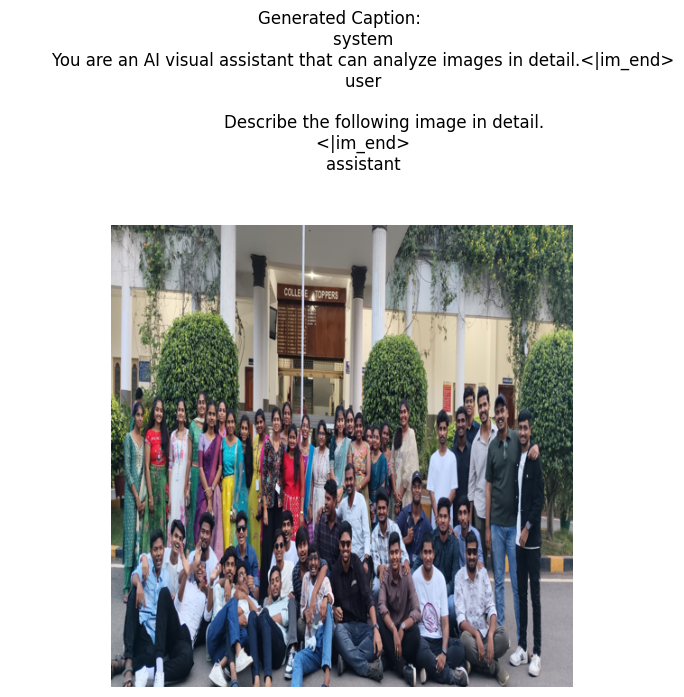

In [27]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizer parallelism warning

from PIL import Image
import torch
import logging
import matplotlib.pyplot as plt
from IPython.display import display
from transformers import Qwen2VLProcessor

# Configure logging to file for debugging
logging.basicConfig(
    filename="inference.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths and prompts
test_image_path = "/kaggle/input/sample3/WhatsApp Image 2025-04-24 at 20.56.05_addcc3e1.jpg"
system_message = "You are an AI visual assistant that can analyze images in detail."
user_prompt = "Describe the following image in detail."

# Load model and processor
try:
    # If model and processor are in memory from training
    model = trainer.model
    processor = trainer.processing_class
except NameError:
    # Load from saved checkpoint
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        "outputs",  # Update to your saved checkpoint path
        load_in_4bit=True,
        dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    )
    processor = Qwen2VLProcessor.from_pretrained("unsloth/Qwen2-VL-2B-Instruct")

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Load and preprocess image
try:
    image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # Resize for consistency
    logger.info(f"Image loaded successfully: {test_image_path}")
except Exception as e:
    logger.error(f"Failed to load image {test_image_path}: {e}")
    print(f"Error: Failed to load image. Check inference.log for details.")
    raise

# Prepare messages
messages = [
    {"role": "system", "content": [{"type": "text", "text": system_message}]},
    {"role": "user", "content": [
        {"type": "image", "image": test_image_path},  # Path for message structure
        {"type": "text", "text": user_prompt}
    ]}
]

try:
    # Apply chat template
    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    logger.info(f"Applied chat template: {text}")

    # Process text and image
    inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
    logger.info(f"Inputs prepared: input_ids shape {inputs['input_ids'].shape}, pixel_values shape {inputs.get('pixel_values', 'Not present').shape}")

    # Generate caption
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    
    # Display image and caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Generated Caption: {generated_text}", fontsize=12, pad=10)
    plt.show()

except Exception as e:
    logger.error(f"Inference failed: {e}")
    print(f"Inference failed: Check inference.log for details")
    raise

# Clear cache
import gc
gc.collect()
torch.cuda.empty_cache()

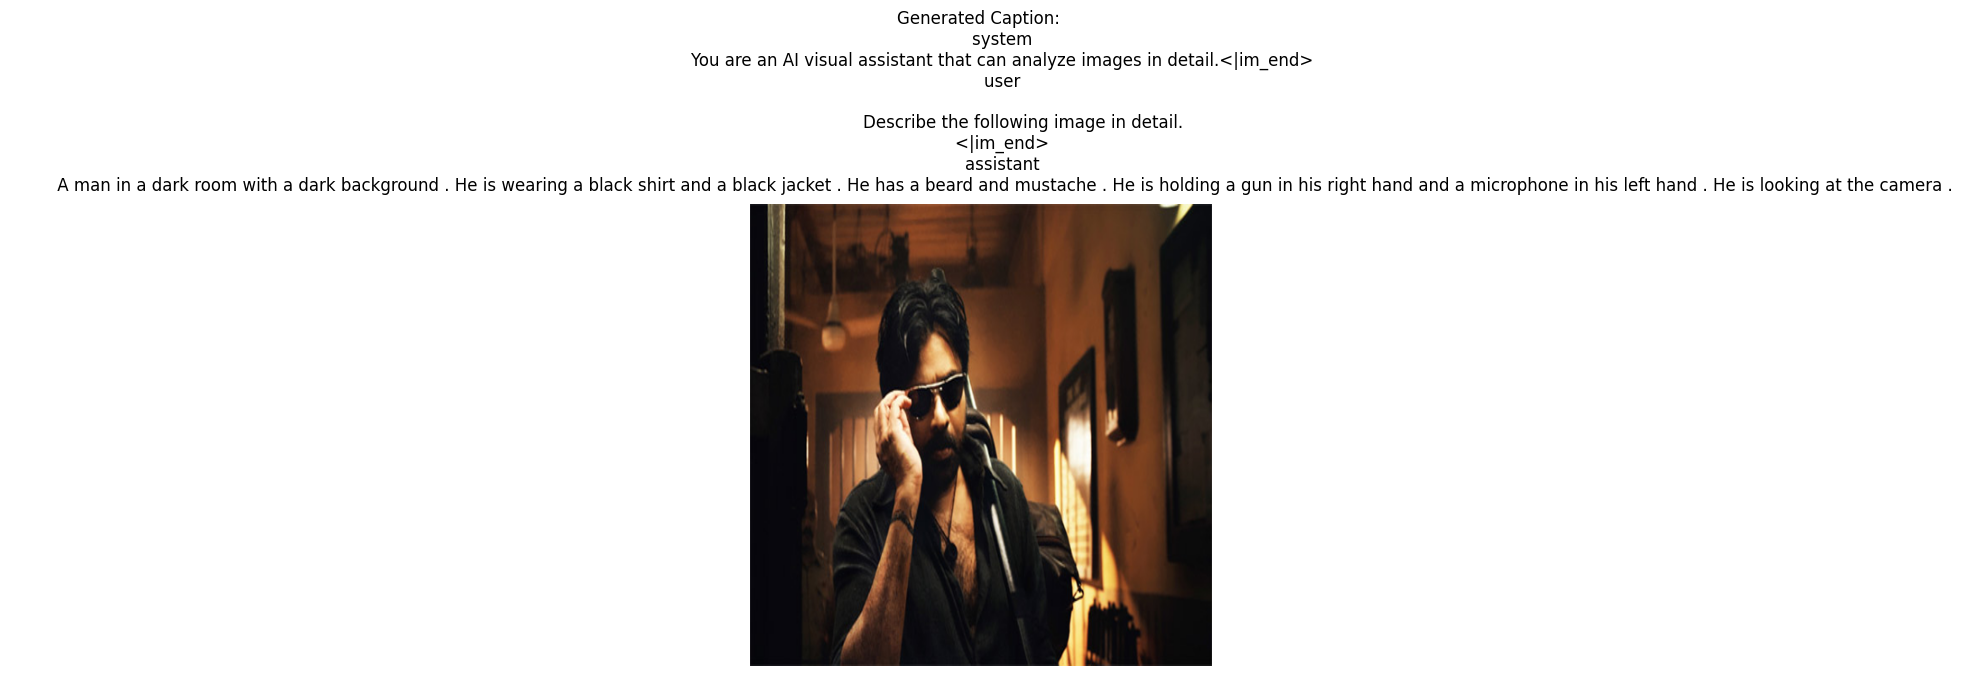

In [28]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizer parallelism warning

from PIL import Image
import torch
import logging
import matplotlib.pyplot as plt
from IPython.display import display
from transformers import Qwen2VLProcessor

# Configure logging to file for debugging
logging.basicConfig(
    filename="inference.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# Define paths and prompts
test_image_path = "/kaggle/input/sample6/OG.jpg"
system_message = "You are an AI visual assistant that can analyze images in detail."
user_prompt = "Describe the following image in detail."

# Load model and processor
try:
    # If model and processor are in memory from training
    model = trainer.model
    processor = trainer.processing_class
except NameError:
    # Load from saved checkpoint
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        "outputs",  # Update to your saved checkpoint path
        load_in_4bit=True,
        dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    )
    processor = Qwen2VLProcessor.from_pretrained("unsloth/Qwen2-VL-2B-Instruct")

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Load and preprocess image
try:
    image = Image.open(test_image_path).convert("RGB").resize((512, 512))  # Resize for consistency
    logger.info(f"Image loaded successfully: {test_image_path}")
except Exception as e:
    logger.error(f"Failed to load image {test_image_path}: {e}")
    print(f"Error: Failed to load image. Check inference.log for details.")
    raise

# Prepare messages
messages = [
    {"role": "system", "content": [{"type": "text", "text": system_message}]},
    {"role": "user", "content": [
        {"type": "image", "image": test_image_path},  # Path for message structure
        {"type": "text", "text": user_prompt}
    ]}
]

try:
    # Apply chat template
    text = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    logger.info(f"Applied chat template: {text}")

    # Process text and image
    inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
    logger.info(f"Inputs prepared: input_ids shape {inputs['input_ids'].shape}, pixel_values shape {inputs.get('pixel_values', 'Not present').shape}")

    # Generate caption
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    
    # Display image and caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f"Generated Caption: {generated_text}", fontsize=12, pad=10)
    plt.show()

except Exception as e:
    logger.error(f"Inference failed: {e}")
    print(f"Inference failed: Check inference.log for details")
    raise

# Clear cache
import gc
gc.collect()
torch.cuda.empty_cache()